## Imports


In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import sys

sys.path.append("..")

from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig, get_device

print(f"pytorch version: {torch.__version__}")

# Is MPS even available? macOS 12.3+
print(torch.backends.mps.is_available())

# Was the current version of PyTorch built with MPS activated?
print(torch.backends.mps.is_built())

pytorch version: 2.4.1
True
True


## Set config


In [17]:
# specifies achitecture and hyperparameters of the language model
llm_config = LLMConfig(
    # size of the vocab the model can understand
    vocab_size=4096,
    # max sequence length of the input tokens; # of tokens model can process in 1 forward pass
    seq_len=128,
    # dimensionality of embedding vectors; each token in vocab is repped by vector of this size
    dim_emb=256,
    # num of layers (or transformer blocks) in the model; each consists of sub-layers like self-attention and feedforward
    num_layers=4,
    # num of attention heads in the multi-head attention mechanism
    num_heads=8,
    # dropout rate applied to embedding layer to prevent overfitting
    emb_dropout=0.0,
    # dimensionality of hidden layer in feedforward network; typically a multiple of 'dim-emb'
    ffn_dim_hidden=4 * 256,
    # whether to include a bias term in the feedforward network layers
    ffn_bias=False,
)

# specifies parameters and settings for training the language model
train_config = TrainingConfig(
    # whether to retrain the tokenizer or not 
    retrain_tokenizer=False,
    # specifies the device to train the model on
    device=get_device(),
    # num of samples per batch of training
    batch_size=64,
    # learning rate for the optimizer; controls how much to adjust the weights w/ respect to the loss gradient
    learning_rate=3e-4,
    # weight decay parameter; helps prevent overfitting by penalizing large weights
    weight_decay=1e-5,
    # max number of epochs (full passes thru training dataset) to train the model for
    max_epochs=1,
    # freq of logging training process (1 = logging after every batch/epoch)
    log_frequency=1,
)

## Prepare tokenizer and dataset


In [18]:
# specifies path to input text file used for training or retraining tokenizer
input_file = "../data/shakespeare/tinyshakespeare.txt"
# creates new file path for tokenizer model by changing suffix of input file
output_file = Path(input_file).with_suffix(".model")

# checks whether tokenizer model file alr exists or if config specifies to retrain tokenizer
if not output_file.exists() or train_config.retrain_tokenizer:
    # train tokenizer sing input text file and specified vocab size from 'LLMConfig'
    train_tokenizer(input_file, llm_config.vocab_size)

# initialize tokenizer by loading it from 'output_file'
tokenizer = Tokenizer(str(output_file))

In [19]:
# defines a string 'sentence' that will be tokenized
sentence = "Before we proceed any further, hear me speak."
# uses 'EncodeAsPieces' method from 'tokenizer.sp' object to tokenize sentence into tokens and outputs them
print(tokenizer.sp.EncodeAsPieces(sentence))

# ensures that the encoding and decoding returns the original sentence
assert tokenizer.decode(tokenizer.encode(sentence)) == sentence

['▁Before', '▁we', '▁proceed', '▁any', '▁further', ',', '▁hear', '▁me', '▁speak', '.']


In [20]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict

# initializes instance of 'NextTokenPredictionDataset' class; dataset responsible for generating batches of input sequences and corresponding target sequences for training
ds_train = NextTokenPredictionDataset(input_file, llm_config.seq_len, tokenizer)
# initializes 'Dataloader' instance that's responsible for creating batches of data from the dataset
dl_train = DataLoader(ds_train, batch_size=train_config.batch_size, shuffle=True)

# iterates over the batches generates by the data loader
for inputs, labels in dl_train:
    # prints shapes of 'inputs' and 'labels' tensors; helps verify dimensions of batches
    print(inputs.shape, labels.shape)
    break

torch.Size([64, 128]) torch.Size([64, 128])


## Define model


In [21]:
# initializes instance of 'LLM' class; represents the language model
model = LLM(
    # size of the vocabulary (# of unique tokens)
    vocab_size=tokenizer.vocab_size,
    # max sequence length (# of tokens per input sequence)
    seq_len=llm_config.seq_len,
    # dimensionality of embeddings vectors
    dim_emb=llm_config.dim_emb,
    # number of layers (transformer block) in the model
    num_layers=llm_config.num_layers,
    # number of attention heads in the multi-head attention mechanism
    attn_num_heads=llm_config.num_heads,
    # dropout rate applied to the embedding layer
    emb_dropout=llm_config.emb_dropout,
    # dimensionality of the hidden layer in the feedforward network
    ffn_hidden_dim=llm_config.ffn_dim_hidden,
    # whether to include a bias term in the feedforward network layers
    ffn_bias=llm_config.ffn_bias,
)

# calc total size of model parameters in bytes by summing product of # of elements and size of each element for each parameter tensor
params_size = sum(p.nelement() * p.element_size() for p in model.parameters())
# calc total size of model buffers (running avgs for batch normalization) in bytes in a similar manner
buffer_size = sum(p.nelement() * p.element_size() for p in model.buffers())
# converts total size from bytes to megabytes by dividing by 1024**2
size = (params_size + buffer_size) / 1024**2

# print total # of parameters in the model
print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
# print total size of the model in megabites, formatted to 3 decimal places
print(f"model size: {size:.3f}MB")

# print(model)

total params: 12,597,504
model size: 48.243MB


## Count parameters

In [22]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}\n")
    return total_params

count_parameters(model)

+----------------------------------------------+------------+
|                   Modules                    | Parameters |
+----------------------------------------------+------------+
|            token_embedding.weight            |  1048576   |
|         transformer.0.norm_attn.gain         |    256     |
| transformer.0.multihead_attn.proj_qkv.weight |   196608   |
| transformer.0.multihead_attn.proj_out.weight |   65536    |
|         transformer.0.norm_ffn.gain          |    256     |
|     transformer.0.feed_forward.0.weight      |   262144   |
|  transformer.0.feed_forward.1.linear.weight  |  2097152   |
|   transformer.0.feed_forward.1.linear.bias   |    2048    |
|     transformer.0.feed_forward.2.weight      |   262144   |
|         transformer.1.norm_attn.gain         |    256     |
| transformer.1.multihead_attn.proj_qkv.weight |   196608   |
| transformer.1.multihead_attn.proj_out.weight |   65536    |
|         transformer.1.norm_ffn.gain          |    256     |
|     tr

12597504

## Train model


In [23]:
# calls 'train' fxn to train the language model
loss_history = train(
    # language model instance to be trained
    model,
    # data loader that provides batches of training data
    dl_train,
    # device on which to train the model
    train_config.device,
    # learning rate for the optimizer
    lr=train_config.learning_rate,
    # max num of epochs to train the model
    max_epochs=train_config.max_epochs,
    # weight decay parameter to prevent overfitting
    weight_decay=train_config.weight_decay,
    # frequency of logging training progress
    log_every=train_config.log_frequency,
)

Training on mps.
Epoch 1/1:
Step 5539/5539 - LR:0.0003 - train_loss: 1.933


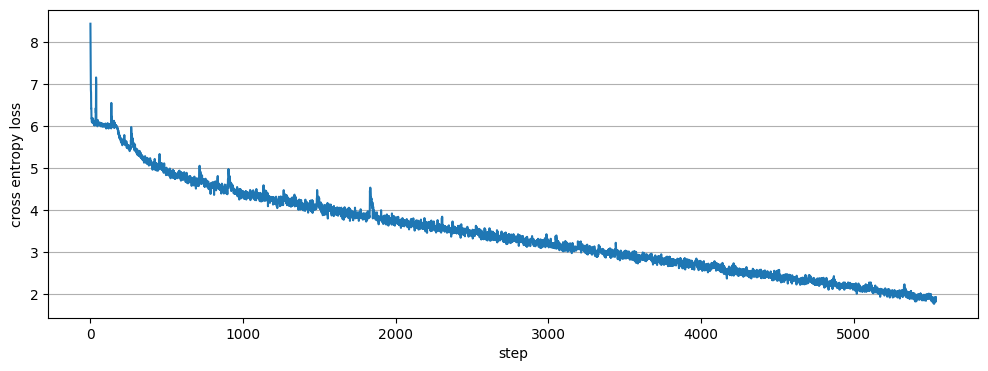

In [24]:
# creates new figure and axis object for the plot and sets the size of the figure
fig, ax = plt.subplots(figsize=(12, 4))
# line plots training loss over time
# x-axis: seq of ints from 0 to len of 'train_loss' list minus 1
# y-axis: recorded training loss values
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
# sets label for the x-axis 
ax.set_xlabel("step")
# sets label for the y-axis
ax.set_ylabel("cross entropy loss")
# adds horizontal grid lines to the plot, making it easier to read the y-axis values
ax.grid(axis="y")

## Play around


In [25]:
# empty prompt to generate random stuff
# create 2D tensor w/ 1 row and 'llm_config.seq_len' cols, filled w/ the end-of-seq token ID and containing 32-bit ints
prompt = torch.full((1, llm_config.seq_len), tokenizer.eos_id, dtype=torch.int32)
# moves tensor to specified device for efficient computation
prompt = prompt.to(train_config.device)

# generates seq of tokens using the model starting from the 'prompt'
out = model.generate(prompt, max_seq_len=64)
# decodes generated seq of token IDs back into a human-readable string
tokenizer.decode(out.tolist())

''

In [26]:
# generate from a prompt
# encodes string into seq of token IDs using the tokenizer
prompt = tokenizer.encode(
    # prompt text to be encoded 
    "KING HENRY VI:",
    # indicates this is the beginning of the string
    beg_of_string=True,
    # pads the sequence to the specified length
    pad_seq=True,
    # length to which the sequence should be padded or truncated
    seq_len=llm_config.seq_len,
)
# converts encoded prompt to a PyTorch tensor and moves it to the specified device
# 'torch.tensor(prompt, dtype=torch.int32)' converts prompt to a tensor w/ 32-bit int type
# '.unsqueeze(0)' adds extra dimension at the beginning, making the tensor shape '(1, seq_len)'
# '.to(train_config.device)' moves the tensor to the specified device
inputs = torch.tensor(prompt, dtype=torch.int32).unsqueeze(0).to(train_config.device)
# generates seq of tokens starting from the given prompt
out = model.generate(inputs, max_seq_len=64)
# decodes generated seq of token IDs back into a human-readable string
tokenizer.decode(out.tolist())

"KING HENRY VI: For, sweet despair. Fare: so gentlemen, And, to anderriyolyiness of England's throne; Who is't, for men and art when says Bolingbroke, And let us live to make the seat to rear, And be inherit'd the strong of"

## Export to ONNX format

In [28]:
import torch.onnx

# generate tensor of random ints betweem 0 and vocab size
# (64, 128) is shape of tensor: 64 = batch size, 128 = sequence length
dummy_input = torch.randint(0, tokenizer.vocab_size, (64, 128), dtype=torch.int32).to(train_config.device)

torch.onnx.export(model,   # trained model to convert to ONNX format
                  dummy_input,   # tensor that mimics input to model; used to trace model and determine input and output shapes
                  "shakespeare_model.onnx",   # name of file to save ONNX model to
                )